In [95]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from jre_utils.datapath import model_ready_data_paths

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [96]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [97]:
metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
}

metric = metrics["weighted_median"]
metric_pct_chg = metric + "_pct_chg"

In [98]:
start_year = 2006
eval_start_year = 2021 # eval_years = [2021]

dataset_key = "transactions"
model_ready_data_path = model_ready_data_paths[f"sequence_{dataset_key}"]
df = pd.read_csv(model_ready_data_path)
train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
eval_df = df[df["year"] >= eval_start_year]

In [99]:
columns = [
    metric,
    "count",
    "total_traded_area",
    "population",
    "taxpayer_count",
    "taxable_income",
    "new_dwellings",
    "existing_dwellings",
    "new_dwellings_ratio",
    "net_migration_ratio",
]
columns_normalized = [f"{col}_normalized" for col in columns]

train_df_mean = train_df[columns].mean()
train_df_std = train_df[columns].std()
train_df[columns_normalized] = (train_df[columns] - train_df_mean) / train_df_std
eval_df[columns_normalized] = (eval_df[columns] - train_df_mean) / train_df_std
df = pd.concat([train_df, eval_df])

In [100]:
class TimeSeriesDataset(Dataset):
    def __init__(
        self,
        complete_df,
        df,
        metrics=[metric_pct_chg],
        feature_columns=None,
        shift=1,
        window_length=5,
        transform=None,
    ):
        self.feature_columns = feature_columns if feature_columns is not None else df.columns
        self.complete_df = complete_df
        self.df = df
        self.transform = transform
        self.metrics = metrics
        self.shift = shift
        self.window_length = window_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.df.iloc[idx]
        target = row[self.metrics]
        area_code, year = row["area_code"], row["year"]
        area_df = (
            self.complete_df[
                (self.complete_df["area_code"] == area_code)
                & (self.complete_df["year"] <= year - self.shift)
            ]
            .sort_values(by="year")  # sorting just to be safe
            .tail(self.window_length)
        )

        sample = {
            "window": area_df[self.feature_columns],
            "target": target,
        }

        if self.transform:
            sample = self.transform(sample)

        return sample


class ToNumpy(object):
    """Convert pandas dataframes in sample to ndarrays."""

    def __call__(self, sample):
        window, target = sample["window"], sample["target"]
        return {"window": window.values, "target": target.values}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        window, target, mask = sample["window"], sample["target"], sample["mask"]
        return {
            "window": torch.from_numpy(window),
            "mask": torch.from_numpy(mask),
            "target": torch.from_numpy(target),
        }


class PadAndMask(object):
    """Pad all inputs to be of the same length and create a mask"""

    def __init__(self, pad_length=5):
        self.pad_length = pad_length

    def __call__(self, sample):
        window, target = sample["window"], sample["target"]

        # the first n elements of the mask are 1, the rest are 0
        mask = np.zeros(self.pad_length)
        mask[: window.shape[0]] = 1

        padded_window = np.pad(
            window, ((0, self.pad_length - window.shape[0]), (0, 0)), "constant"
        )
        return {"window": padded_window, "mask": mask, "target": target}

In [101]:
feature_columns = [metric_pct_chg] + columns_normalized
time_series_dataset = TimeSeriesDataset(df, train_df, feature_columns=feature_columns)
time_series_dataset_transformed = TimeSeriesDataset(
    df, train_df, transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()])
)

for i, sample in enumerate(time_series_dataset):
    print(i, sample["window"].shape, sample["target"].shape, sample["target"])
    if i == 3:
        break


for i, sample in enumerate(time_series_dataset_transformed):
    print(i, sample["window"].shape, sample["target"].shape, sample["target"])
    if i == 3:
        break

0 (0, 11) (1,) unit_price_wmedian_pct_chg   -0.426053
Name: 0, dtype: float64
1 (1, 11) (1,) unit_price_wmedian_pct_chg   -0.087079
Name: 1, dtype: float64
2 (2, 11) (1,) unit_price_wmedian_pct_chg    0.389261
Name: 2, dtype: float64
3 (3, 11) (1,) unit_price_wmedian_pct_chg   -0.231734
Name: 3, dtype: float64
0 torch.Size([5, 23]) torch.Size([1]) tensor([-0.4261], dtype=torch.float64)
1 torch.Size([5, 23]) torch.Size([1]) tensor([-0.0871], dtype=torch.float64)
2 torch.Size([5, 23]) torch.Size([1]) tensor([0.3893], dtype=torch.float64)
3 torch.Size([5, 23]) torch.Size([1]) tensor([-0.2317], dtype=torch.float64)


In [102]:
train_dataset = TimeSeriesDataset(
    df, train_df, feature_columns=feature_columns, transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()])
)
eval_dataset = TimeSeriesDataset(
    df, eval_df, feature_columns=feature_columns, transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()])
)


In [103]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=0)
eval_dataloader = DataLoader(eval_dataset, batch_size=32, shuffle=False, num_workers=0)

In [104]:
for i, sample in enumerate(train_dataloader):
    print(i, sample["window"].shape, sample["target"].shape)
    if i == 0:
        break

0 torch.Size([32, 5, 11]) torch.Size([32, 1])


### Building the Transformer Model

In [167]:
import math

from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer


In [168]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class TimeSeriesTransformerModel(nn.Module):
    def __init__(
            self,
            n_features: int,
            d_model: int,
            nhead: int, 
            d_hid: int, 
            nlayers: int,
            dropout: float = 0.1,
            device: str = "cpu",
    ):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(n_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(self.encoder_layers, nlayers)
        self.linear = nn.Linear(d_model, 1)
        self.device = device

    def init_weights(self) -> None:
        initrange = 0.1
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, window: Tensor, mask: Tensor) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[batch_size, seq_len, n_features]`` -> ``[seq_len, batch_size, n_features]`` 
            src_mask: Tensor, shape ``[batch_size, seq_len]``
        
        Returns:
            output: Tensor, shape ``[batch_size, 1]``
        """
        window = window.permute(1, 0, 2)
        window = self.embedding(window)
        window = self.pos_encoder(window)
        output_layer = self.transformer_encoder(window, src_key_padding_mask=mask)
        pooled_output = torch.mean(output_layer, dim=0)
        final_output = self.linear(pooled_output)
        return final_output

In [169]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [181]:
n_features = len(feature_columns)
d_model = 256
d_hid = 512
nlayers = 8
nhead = 8
dropout = 0.1

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    device=device,
)

In [182]:
data_iter = iter(train_dataloader)
batch = next(data_iter)
print(batch['window'].shape, batch['mask'].shape, batch['target'].shape)


torch.Size([32, 5, 11]) torch.Size([32, 5]) torch.Size([32, 1])


In [183]:
window = batch['window'].to(torch.float32).to(device)
mask = batch['mask'].to(torch.float32).to(device)
target = batch['target'].to(torch.float32).to(device)
model = model.to(device)

In [184]:
output = model(window, mask)
output.shape


torch.Size([32, 1])

In [185]:
learning_rate = 1e-4
num_epochs = 30

In [186]:
from transformers import AdamW, get_scheduler

optimizer = AdamW(model.parameters(), lr=learning_rate)
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

9690


In [187]:
from tqdm.auto import tqdm
from torch.nn import MSELoss
from torcheval.metrics import R2Score

mse_loss = MSELoss()

progress_bar = tqdm(range(num_training_steps))

train_losses, train_r2_scores, eval_losses, eval_r2_scores = [], [], [], []

phases = ["train", "eval"]

for epoch in range(num_epochs):
    running_loss = 0.0
    r2_score = R2Score(device=device)

    for phase in phases:
        if phase == "train":
            model.train()
            dataloader, losses, r2_scores = train_dataloader, train_losses, train_r2_scores
        else:
            model.eval()
            dataloader, losses, r2_scores = eval_dataloader, eval_losses, eval_r2_scores

        for batch in dataloader:
            window = batch["window"].to(torch.float32).to(device)
            mask = batch["mask"].to(torch.float32).to(device)
            target = batch["target"].to(torch.float32).to(device)

            outputs = model(window, mask)
            loss = mse_loss(outputs, target)

            if phase == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                progress_bar.update(1)

            running_loss += loss.item() * len(batch)
            r2_score.update(outputs, target)

        losses.append(running_loss / len(train_dataloader))
        r2_scores.append(r2_score.compute().item())

progress_bar.close()

100%|██████████| 9690/9690 [20:56<00:00,  7.71it/s]  


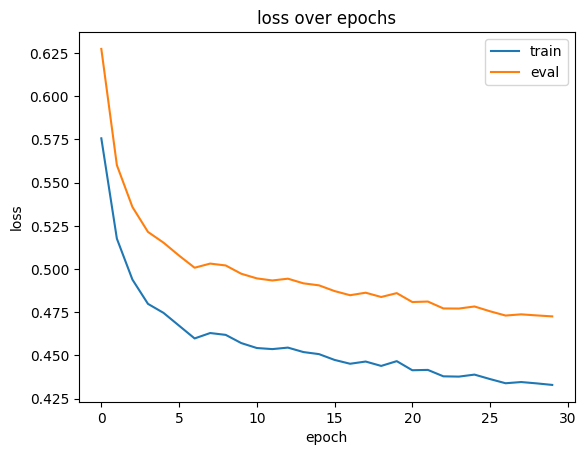

In [188]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

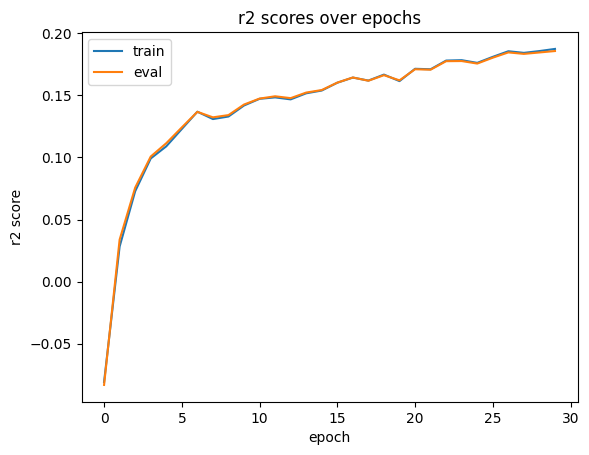

In [189]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

In [ ]:
# How do I make the model better?
# Model is currently underfitting. Make it overfit first.

# Basic
# Hyperparameter Tuning
#   1. Learning rate.
#   2. No. of hidden units.
#   3. No. of layers.
# Alternative Cost Function
#   1. Weighted MSE loss - Weighted on count

# Advanced
# Pretrain on the Time Series Datasets
